# **Modelos de Machine Learning para (a)predição de receita e (b)análise de comentários de produtos de um e-commerce**

## Informações gerais

Esse notebook é baseado em um conjunto de dados disponibilizado por um e-commerce brasileiro sob a licença CC BY-NC-SA 4.0.

O conjunto de dados foi disponibilizado em 8 arquivos .csv que se relacionam da seguinte forma:

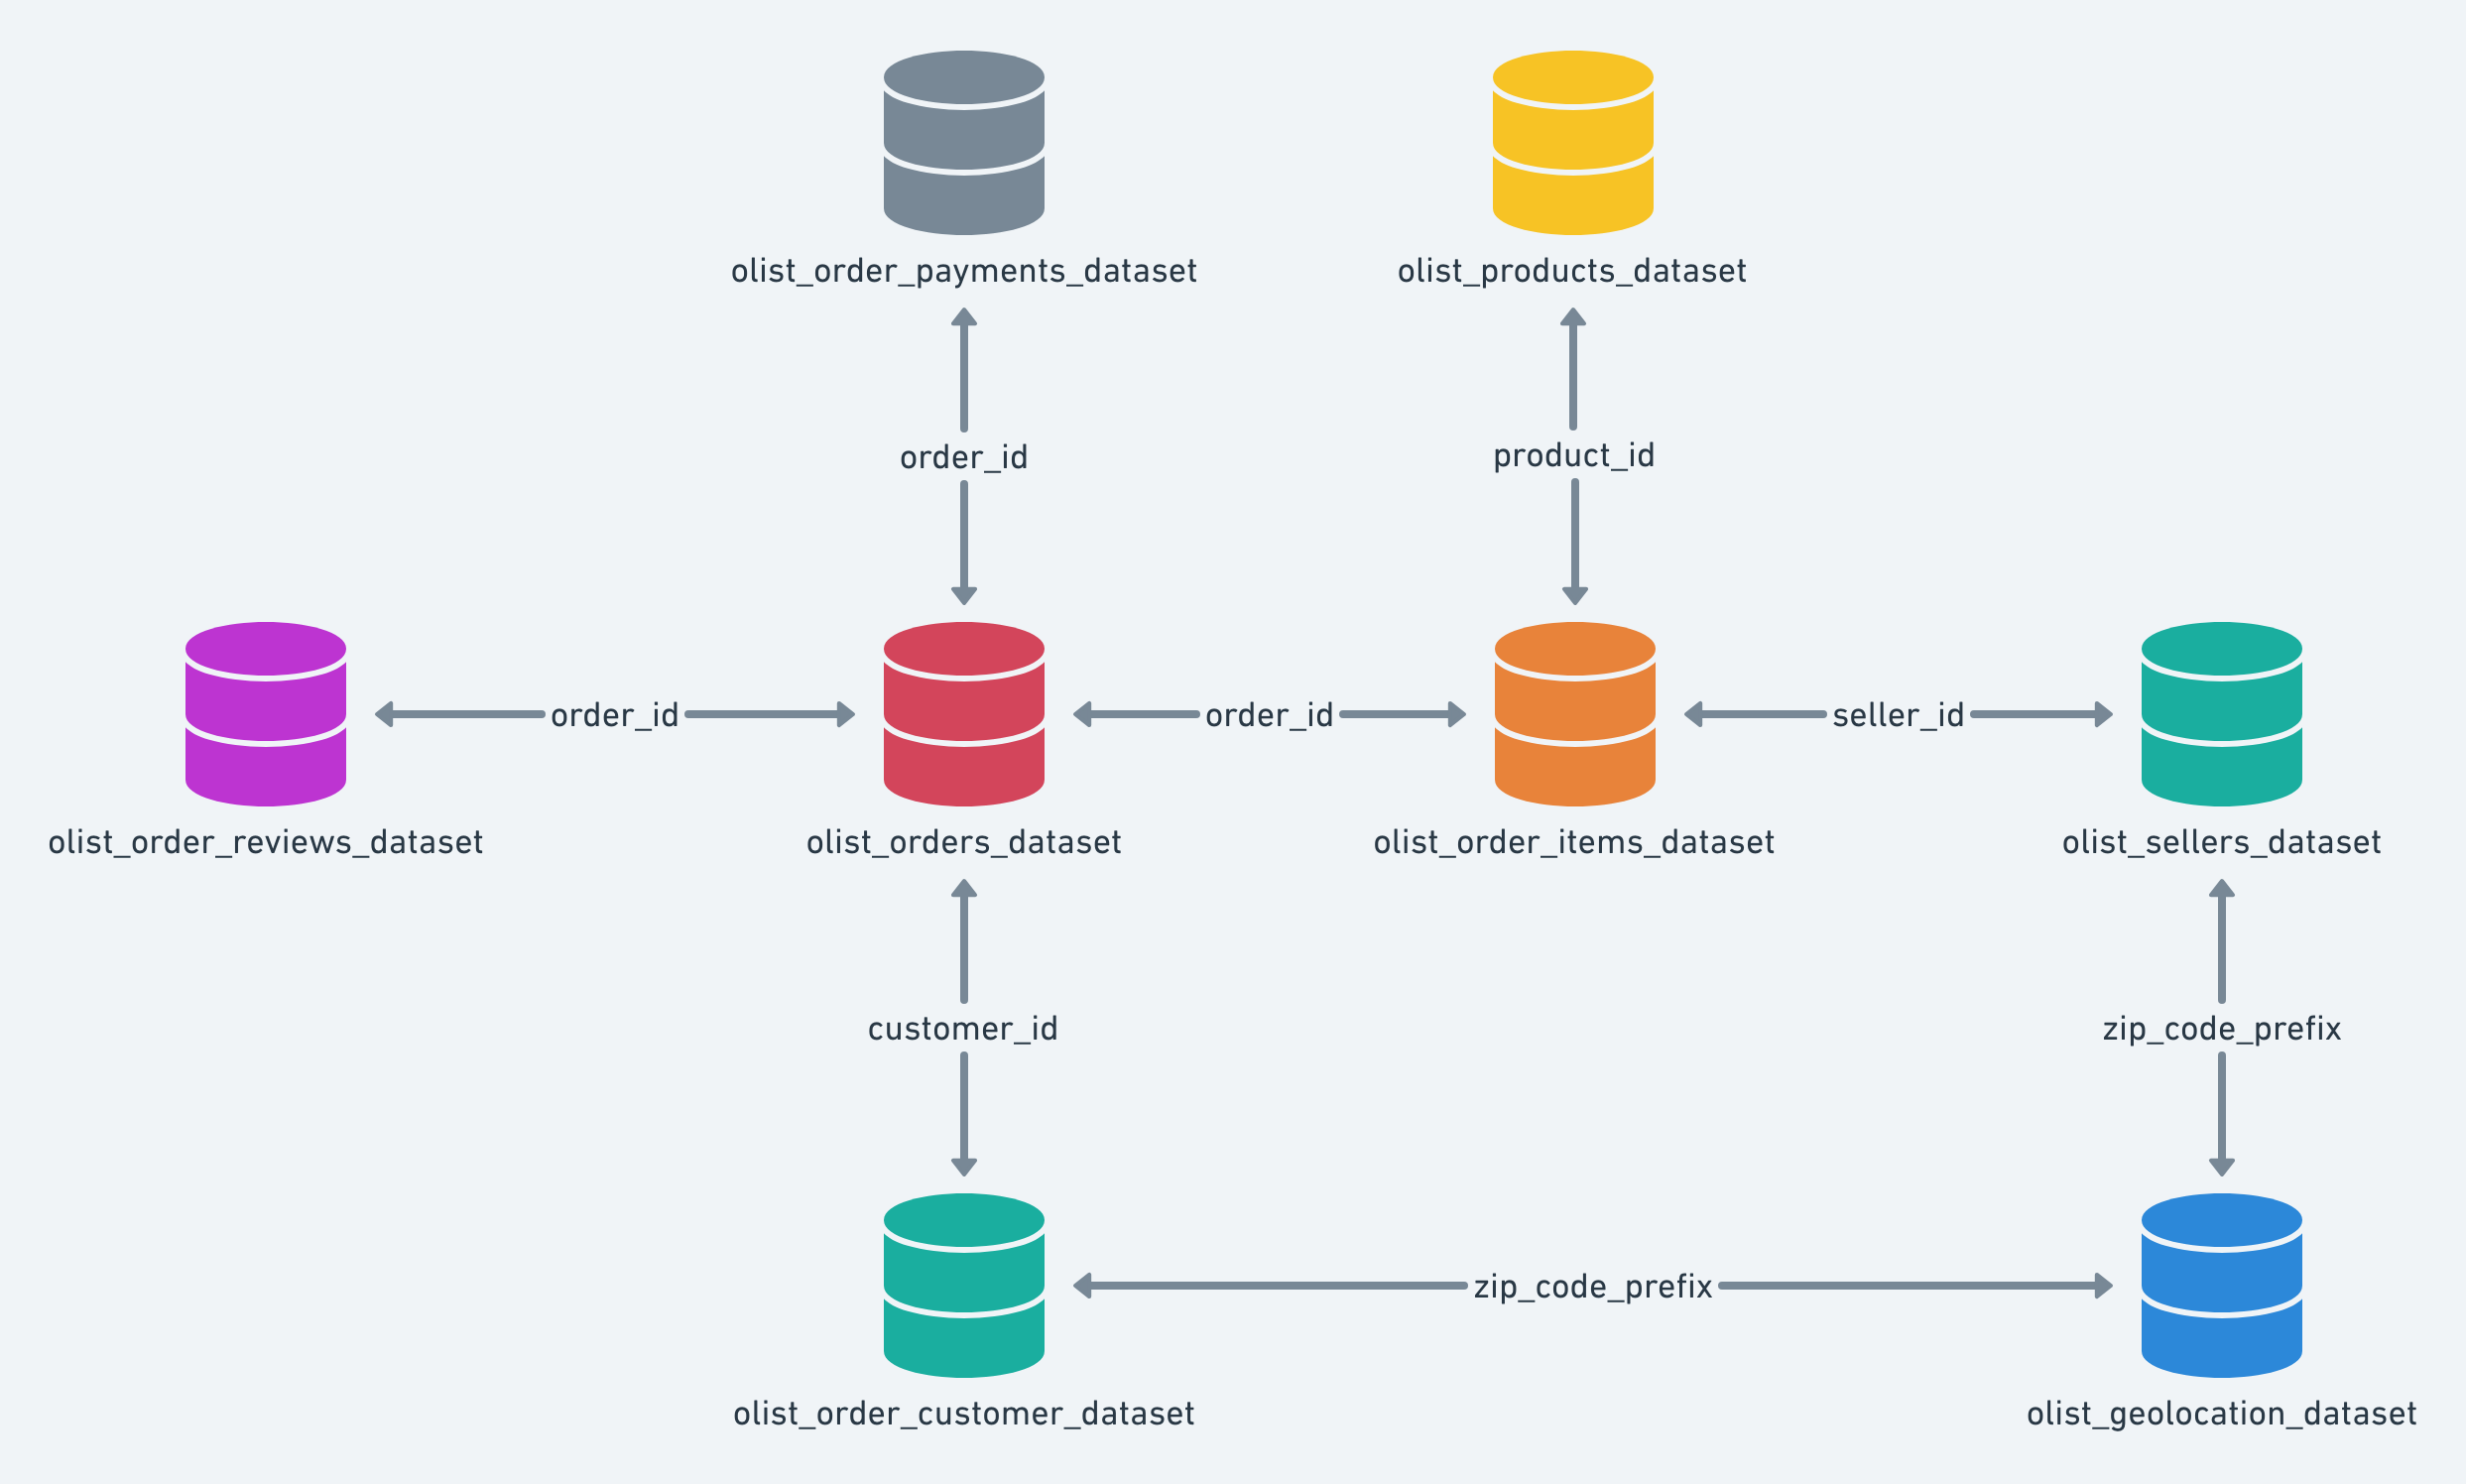

## Definição do problema

A partir dos dados fornecidos, serão desenvolvidos dois modelos de machine learning:

a. Modelo de regressão com o objetivo de prever as receitas futuras do negócio de acordo com a categoria do produto e a cidade do cliente.

b. Modelo de processamento de linguagem natural para análise de sentimentos de review de clientes.

O conjunto de dados contém os seguintes atributos:

**ORDERS**  
order_id  
idetificador único do pedido - chave para as tabelas order_items, order_payments e order_reviews.

customer_id  
chave para o dataset customer. cada pedido tem um customer_id único - chave para a tabela customers.

order_status  
status do pedido (entregue, enviado, cancelado etc).

order_purchase_timestamp  
timestamp do ato da compra.

order_approved_at  
timestamp da aprovação do pagamento.

order_delivered_carrier_date  
timestamp da postagem do pedido, quando ele foi entregue ao parceiro logístico.

order_delivered_customer_date  
data que o pedido foi entregue ao cliente.

order_estimated_delivery_date  
data estimada de entrega informada ao cliente no ato da compra.

**ORDER_ITEMS**  
order_id  
identificador único do pedido - chave para a tabela orders  

order_item_id  
número sequencial identificando o número dos itens inclusos no mesmo pedido   

product_id  
identificador único do produto - chave para a tabela products

seller_id  
identificador único do vendedor - chave para a tabela sellers  

shipping_limit_date  
data limite para o vendedor entregar o pedido para o parceiro logístico

price  
preço do item

freight_value  
valor do frete do item - se o pedido tem mais de um item, o valor do frete é dividido entre os itens de acordo com suas medidas e peso.

**PRODUCTS**  
product_id  
identificador único do pedido - chave para a tabela order_items  

product_category_name  
categoria do produto, em português

product_name_lenght  
número de caracteres do nome do produto

product_description_lenght  
número de caracteres da descrição do produto

product_photos_qty  
número de fotos publicadas do produto

product_weight_g  
peso do produto em gramas

product_length_cm  
comprimento do produto em centímetros

product_height_cm  
altura do produto em centímetros

product_width_cm  
largura do produto em centímetros

**CUSTOMERS**  
customer_id  
cada pedido possui um único identificador - chave para a tabela orders

customer_unique_id  
identificador único de um cliente

customer_zip_code_prefix  
primeiros 5 dígitos do cep do cliente

customer_city  
nome da cidade do cliente

customer_state  
nome do Estado do cliente

**SELLERS**  
seller_id  
identificador único do vendedor - chave para a tabela order_items

seller_zip_code_prefix  
primeiros 5 dígitos do cep do vendedor

seller_city  
nome da cidade do vendedor

seller_state  
nome do Estado do vendedor

**ORDER_PAYMENTS**  
order_id  
identificador único do pedido - chave para a tabela orders

payment_sequential  
um cliente pode pagar um pedido com mais de uma forma de pagamento. Se isso acontecer, uma sequência é criada para acomodar todos os pagamentos.

payment_type  
método de pagamento escolhido pelo cliente

payment_installments  
número de parcelas escolhido pelo cliente

payment_value  
valor da transação

**ORDER_REVIEWS**  
review_id  
identificador único do review

order_id  
identificador único do pedido - chave para a tabela orders

review_score  
nota de 1 a 5 dada pelo cliente na pesquisa de satisfação

review_comment_title  
título do comentário do review feito pelo cliente

review_comment_message  
comentário do review feito pelo cliente

review_creation_date  
data em que a pesquisa de satisfação foi enviada ao cliente

review_answer_timestamp  
data em que a pesquisa de satisfação foi respondida pelo cliente

## (a) Modelo de regressão para predição de receita

### Pré-processamento dos dados

In [1]:
# importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error # métrica de avaliação MSE
from sklearn.linear_model import LinearRegression # algoritmo Regressão Linear
from sklearn.linear_model import Ridge # algoritmo Regularização Ridge
from sklearn.linear_model import Lasso # algoritmo Regularização Lasso
from sklearn.neighbors import KNeighborsRegressor # algoritmo KNN
from sklearn.tree import DecisionTreeRegressor # algoritmo Árvore de Regressão
from sklearn.svm import SVR # algoritmo SVM

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# importando os arquivos .csv para dataframes
# o parametro parse_dates lista os atributos que são datas e os transforma em objetos datetime
orders = pd.read_csv ('https://raw.githubusercontent.com/vitorjannes/ecommerce_data/main/olist_orders_dataset.csv', 
                      parse_dates=['order_purchase_timestamp',
                                   'order_approved_at',
                                   'order_delivered_carrier_date',
                                   'order_delivered_customer_date',
                                   'order_estimated_delivery_date'])
order_items = pd.read_csv ('https://raw.githubusercontent.com/vitorjannes/ecommerce_data/main/olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])
products = pd.read_csv ('https://raw.githubusercontent.com/vitorjannes/ecommerce_data/main/olist_products_dataset.csv')
customers = pd.read_csv ('https://raw.githubusercontent.com/vitorjannes/ecommerce_data/main/olist_customers_dataset.csv')

In [3]:
# resumo estatístico
orders.describe(include='all', datetime_is_numeric=True)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,NaN,NaN,NaN,NaN,NaN
top,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,NaN,NaN,NaN,NaN,NaN
freq,1,1,96478,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,2017-12-31 08:43:12.776581120,2017-12-31 18:35:24.098800128,2018-01-04 21:49:48.138278656,2018-01-14 12:09:19.035542272,2018-01-24 03:08:37.730111232
min,NaN,NaN,NaN,2016-09-04 21:15:19,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-09-30 00:00:00
25%,NaN,NaN,NaN,2017-09-12 14:46:19,2017-09-12 23:24:16,2017-09-15 22:28:50.249999872,2017-09-25 22:07:22.249999872,2017-10-03 00:00:00
50%,NaN,NaN,NaN,2018-01-18 23:04:36,2018-01-19 11:36:13,2018-01-24 16:10:58,2018-02-02 19:28:10.500000,2018-02-15 00:00:00
75%,NaN,NaN,NaN,2018-05-04 15:42:16,2018-05-04 20:35:10,2018-05-08 13:37:45,2018-05-15 22:48:52.249999872,2018-05-25 00:00:00
max,NaN,NaN,NaN,2018-10-17 17:30:18,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-11-12 00:00:00


Neste dataset existem informações de 99 mil pedidos realizados de set/2016 a out/2018.

Para este modelo de previsão de receita só usaremos um atributo do conjunto 'orders', o 'order_purchase_timestamp', que nos mostra a data de realização do pedido pelo cliente.

In [4]:
# resumo estatístico
order_items.describe(include='all', datetime_is_numeric=True)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
count,112650,112650.000000,112650,112650,112650,112650.000000,112650.000000
unique,98666,NaN,32951,3095,NaN,NaN,NaN
top,8272b63d03f5f79c56e9e4120aec44ef,NaN,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,NaN,NaN,NaN
freq,21,NaN,527,2033,NaN,NaN,NaN
mean,NaN,1.197834,NaN,NaN,2018-01-07 15:36:52.192685312,120.653739,19.990320
min,NaN,1.000000,NaN,NaN,2016-09-19 00:15:34,0.850000,0.000000
25%,NaN,1.000000,NaN,NaN,2017-09-20 20:57:27.500000,39.900000,13.080000
50%,NaN,1.000000,NaN,NaN,2018-01-26 13:59:35,74.990000,16.260000
75%,NaN,1.000000,NaN,NaN,2018-05-10 14:34:00.750000128,134.900000,21.150000
max,NaN,21.000000,NaN,NaN,2020-04-09 22:35:08,6735.000000,409.680000


Neste conjunto de dados existem informações de 98 mil pedidos distintos que contêm 112 mil itens vendidos no total. Deste conjunto, será utilizado o atributo 'price' que é o preço do produto vendido.

In [5]:
# resumo estatístico
products.describe(include='all', datetime_is_numeric=True)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32951,32341,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000
unique,32951,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,1e9e8ef04dbcff4541ed26657ea517e5,cama_mesa_banho,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,3029,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,48.476949,771.495285,2.188986,2276.472488,30.815078,16.937661,23.196728
std,NaN,NaN,10.245741,635.115225,1.736766,4282.038731,16.914458,13.637554,12.079047
min,NaN,NaN,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,NaN,NaN,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,NaN,NaN,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,NaN,NaN,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000


Do conjunto 'products', vamos extrair a informação da categoria do produto 'product_category_name'.

In [6]:
# resumo estatístico
customers.describe(include='all', datetime_is_numeric=True)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
count,99441,99441,99441.000000,99441,99441
unique,99441,96096,NaN,4119,27
top,06b8999e2fba1a1fbc88172c00ba8bc7,8d50f5eadf50201ccdcedfb9e2ac8455,NaN,sao paulo,SP
freq,1,17,NaN,15540,41746
mean,NaN,NaN,35137.474583,NaN,NaN
std,NaN,NaN,29797.938996,NaN,NaN
min,NaN,NaN,1003.000000,NaN,NaN
25%,NaN,NaN,11347.000000,NaN,NaN
50%,NaN,NaN,24416.000000,NaN,NaN
75%,NaN,NaN,58900.000000,NaN,NaN


Do conjunto 'customers', obtemos a localização do cliente pelas variáveis 'customer_city' e 'customer_state'.

In [7]:
# cria um atributo 'customer_loc' concatenando a cidade e o Estado do cliente
customers = customers.assign(customer_loc = customers['customer_city'] + ', ' + customers['customer_state'])

customers

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_loc
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,"franca, SP"
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,"sao bernardo do campo, SP"
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,"sao paulo, SP"
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,"mogi das cruzes, SP"
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,"campinas, SP"
...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,"sao paulo, SP"
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,"taboao da serra, SP"
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,"fortaleza, CE"
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,"canoas, RS"


Para criar o conjunto de dados que será utilizado pelo modelo, são realizadas diversas transformações unindo os conjuntos citados pelas suas chaves e selecionando as variáveis que importam:

In [8]:
# define uma função de rápida performance para conectar dataframes fazendo um 'left join'
# as variáveis dessa função são os nomes dos dataframes, seus atributos a permanecerem no dataframe final e o atributo chave
# a função retorna as colunas selecionadas de df2 adicionadas às colunas selecionadas de df1 em um novo dataframe
def left_join(df1, variables_df1, df2, variables_df2, key):
    # seleciona somente os atributos necessários dos dataframes
    df1 = df1[variables_df1]
    df2 = df2[variables_df2]
    
    # para fins de performance, define como index dos dataframes o atributo chave
    df1.set_index(key, inplace=True)
    df2.set_index(key, inplace=True)
    
    # retorna o dataframe final com o left join realizado
    return df1.join(df2, how='left').reset_index()

In [9]:
# conecta a tabela orders com a tabela customers pela chave customer_id criando um novo dataframe df
df = left_join(orders, 
               ['order_id', 
                'customer_id',
                'order_purchase_timestamp'],
               customers,
               ['customer_id',
                'customer_loc'],
               'customer_id')
df

,customer_id,order_id,order_purchase_timestamp,customer_loc
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,"sao paulo, SP"
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,"barreiras, BA"
2,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,"vianopolis, GO"
3,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,"sao goncalo do amarante, RN"
4,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,"santo andre, SP"
...,...,...,...,...
99436,39bd1228ee8140590ac3aca26f2dfe00,9c5dedf39a927c1b2549525ed64a053c,2017-03-09 09:54:05,"sao jose dos campos, SP"
99437,1fca14ff2861355f6e5f14306ff977a7,63943bddc261676b46f01ca7ac2f7bd8,2018-02-06 12:58:58,"praia grande, SP"
99438,1aa71eb042121263aafbe80c1b562c9c,83c1379a015df1e13d02aae0204711ab,2017-08-27 14:46:43,"nova vicosa, BA"
99439,b331b74b18dc79bcdf6532d51e1637c1,11c177c8e97725db2631073c19f07b62,2018-01-08 21:28:27,"japuiba, RJ"


In [10]:
# conecta a tabela order_items com a tabela df pela chave order_id
df = left_join(order_items,
               ['order_id',
                'product_id',
                'price'],
               df,
               df.columns.values.tolist(),
               'order_id')
df

,order_id,product_id,price,customer_id,order_purchase_timestamp,customer_loc
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,58.90,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02,"campos dos goytacazes, RJ"
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,239.90,f6dd3ec061db4e3987629fe6b26e5cce,2017-04-26 10:53:06,"santa fe do sul, SP"
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,199.00,6489ae5e4333f3693df5ad4372dab6d3,2018-01-14 14:33:31,"para de minas, MG"
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,12.99,d4eb9395c8c0431ee92fce09860c5a06,2018-08-08 10:00:35,"atibaia, SP"
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,199.90,58dbd0b2d70206bf40e62cd34e84d795,2017-02-04 13:57:51,"varzea paulista, SP"
...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,299.99,b51593916b4b8e0d6f66f2ae24f2673d,2018-04-23 13:57:06,"sao luis, MA"
112646,fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,350.00,84c5d4fbaf120aae381fad077416eaa0,2018-07-14 10:26:46,"curitiba, PR"
112647,fffce4705a9662cd70adb13d4a31832d,72a30483855e2eafc67aee5dc2560482,99.90,29309aa813182aaddc9b259e31b870e6,2017-10-23 17:07:56,"sao paulo, SP"
112648,fffe18544ffabc95dfada21779c9644f,9c422a519119dcad7575db5af1ba540e,55.99,b5e6afd5a41800fdf401e0272ca74655,2017-08-14 23:02:59,"vinhedo, SP"


In [11]:
# conecta a tabela df com a tabela products pela chave product_id
df = left_join(df,
               df.columns.values.tolist(),
               products,
               ['product_id',
                'product_category_name'],
               'product_id')
df

,product_id,order_id,price,customer_id,order_purchase_timestamp,customer_loc,product_category_name
0,00066f42aeeb9f3007548bb9d3f33c38,f30149f4a8882a08895b6a242aa0d612,101.65,86c180c33f454b35e1596a99da3dddc4,2018-05-20 18:45:21,"teutonia, RS",perfumaria
1,00088930e925c41fd95ebfe695fd2655,f5eda0ded77c1293b04c953138c8331d,129.90,68f2b37558e27791155db34bcded5ac0,2017-12-12 19:20:28,"franca, SP",automotivo
2,0009406fd7479715e4bef61dd91f2462,0bf736fd0fd5169d60de3699fcbcf986,229.00,6cd217b674e22cf568f6a2cf6060fd07,2017-12-21 16:21:47,"sao paulo, SP",cama_mesa_banho
3,000b8f95fcb9e0096488278317764d19,3aba44d8e554ab4bb8c09f6f78032ca8,58.90,82b838f513e00463174cc7cae7e76c1f,2018-08-10 13:24:35,"farroupilha, RS",utilidades_domesticas
4,000b8f95fcb9e0096488278317764d19,6f0dfb5b5398b271cc6bbd9ee263530e,58.90,8517e7c86998bf39a540087da6f115d9,2018-08-01 22:00:33,"novo hamburgo, RS",utilidades_domesticas
...,...,...,...,...,...,...,...
112645,fffdb2d0ec8d6a61f0a0a0db3f25b441,a8159270bc9cf7d54450e079ba6b7232,29.99,839b3007f7e5aee8f8eb130c8fa51c29,2018-04-01 11:58:04,"anapolis, GO",informatica_acessorios
112646,fffdb2d0ec8d6a61f0a0a0db3f25b441,beaf95465b542dea76df78b2fb86a97a,34.99,d14930bf3da4e0ba5a02cc8d6ac80f6e,2018-04-19 10:12:12,"coromandel, MG",informatica_acessorios
112647,fffdb2d0ec8d6a61f0a0a0db3f25b441,d6c1ed12e8eeaa15e9d5c83c79598f85,34.99,550ccac77275f9cdec4b6cd97ac118d0,2018-08-10 17:15:07,"sao paulo, SP",informatica_acessorios
112648,fffdb2d0ec8d6a61f0a0a0db3f25b441,dd38c566a34ff9deb93ff05d7bd6d0aa,34.99,35e8f2cff4eeed925cfa42f6731a4425,2018-05-01 17:31:41,"sao paulo, SP",informatica_acessorios


In [12]:
# descarta atributos que não contribuem para o modelo
df.drop(['product_id', 'order_id', 'customer_id'], axis=1, inplace=True)

df

,price,order_purchase_timestamp,customer_loc,product_category_name
0,101.65,2018-05-20 18:45:21,"teutonia, RS",perfumaria
1,129.90,2017-12-12 19:20:28,"franca, SP",automotivo
2,229.00,2017-12-21 16:21:47,"sao paulo, SP",cama_mesa_banho
3,58.90,2018-08-10 13:24:35,"farroupilha, RS",utilidades_domesticas
4,58.90,2018-08-01 22:00:33,"novo hamburgo, RS",utilidades_domesticas
...,...,...,...,...
112645,29.99,2018-04-01 11:58:04,"anapolis, GO",informatica_acessorios
112646,34.99,2018-04-19 10:12:12,"coromandel, MG",informatica_acessorios
112647,34.99,2018-08-10 17:15:07,"sao paulo, SP",informatica_acessorios
112648,34.99,2018-05-01 17:31:41,"sao paulo, SP",informatica_acessorios


In [13]:
# resumo estatístico
df.describe(include='all', datetime_is_numeric=True)

,price,order_purchase_timestamp,customer_loc,product_category_name
count,112650.000000,112650,112650,111047
unique,NaN,NaN,4300,73
top,NaN,NaN,"sao paulo, SP",cama_mesa_banho
freq,NaN,NaN,17808,11115
mean,120.653739,2018-01-01 00:09:48.464376320,NaN,NaN
min,0.850000,2016-09-04 21:15:19,NaN,NaN
25%,39.900000,2017-09-13 19:17:04,NaN,NaN
50%,74.990000,2018-01-19 23:02:16,NaN,NaN
75%,134.900000,2018-05-04 17:30:36.750000128,NaN,NaN
max,6735.000000,2018-09-03 09:06:57,NaN,NaN


Como resultado, foi obtido um dataframe com informações de 112 mil itens vendidos, seus preços, data do pedido, cidade do cliente e categoria do produto. Estes itens pertencem a 73 categorias diferentes e foram vendidos para 4.300 cidades distintas.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 4 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   price                     112650 non-null  float64       
 1   order_purchase_timestamp  112650 non-null  datetime64[ns]
 2   customer_loc              112650 non-null  object        
 3   product_category_name     111047 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 3.4+ MB


Existem 1.603 itens sem classificação de categoria do produto, com valores nulos para o atributo 'product_category_name'. Vamos excluir esses itens do conjunto:

In [15]:
df = df.dropna(subset=['product_category_name'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111047 entries, 0 to 112649
Data columns (total 4 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   price                     111047 non-null  float64       
 1   order_purchase_timestamp  111047 non-null  datetime64[ns]
 2   customer_loc              111047 non-null  object        
 3   product_category_name     111047 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 4.2+ MB


Como a variável alvo do modelo é a receita mensal, vamos agrupar os dados por mês, categoria do produto e cidade, somando os preços de forma a obter a receita.

In [16]:
# Cria colunas separadas para o ano e o mês
df['order_year'] = df['order_purchase_timestamp'].dt.year
df['order_month'] = df['order_purchase_timestamp'].dt.month

# Calcula a receita mensal para cada combinação de categoria de produto e cidade do cliente
revenue_data = df.groupby(['order_year', 'order_month', 'product_category_name', 'customer_loc'])['price'].sum().reset_index()
# renomeia as colunas
revenue_data.columns = ['order_year', 'order_month', 'product_category_name', 'customer_loc', 'revenue']

revenue_data

C:\Users\vitor\AppData\Local\Temp\ipykernel_15344\3089886068.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['order_year'] = df['order_purchase_timestamp'].dt.year
C:\Users\vitor\AppData\Local\Temp\ipykernel_15344\3089886068.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['order_month'] = df['order_purchase_timestamp'].dt.month


,order_year,order_month,product_category_name,customer_loc,revenue
0,2016,9,beleza_saude,"sao joaquim da barra, SP",134.97
1,2016,9,moveis_decoracao,"boa vista, RR",72.89
2,2016,9,telefonia,"passo fundo, RS",59.50
3,2016,10,alimentos,"guarulhos, SP",79.90
4,2016,10,audio,"rio de janeiro, RJ",132.00
...,...,...,...,...,...
56795,2018,8,utilidades_domesticas,"valinhos, SP",433.10
56796,2018,8,utilidades_domesticas,"varginha, MG",317.00
56797,2018,8,utilidades_domesticas,"venancio aires, RS",99.80
56798,2018,8,utilidades_domesticas,"xanxere, SC",19.00


In [17]:
# resumo estatístico
revenue_data.describe(include='all')

,order_year,order_month,product_category_name,customer_loc,revenue
count,56800.000000,56800.000000,56800,56800,56800.000000
unique,NaN,NaN,73,4283,NaN
top,NaN,NaN,cama_mesa_banho,"sao paulo, SP",NaN
freq,NaN,NaN,4264,965,NaN
mean,2017.508275,6.013504,NaN,NaN,236.128669
std,0.509425,3.220300,NaN,NaN,596.278518
min,2016.000000,1.000000,NaN,NaN,0.850000
25%,2017.000000,3.000000,NaN,NaN,53.900000
50%,2018.000000,6.000000,NaN,NaN,108.900000
75%,2018.000000,8.000000,NaN,NaN,210.940000


In [18]:
revenue_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56800 entries, 0 to 56799
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   order_year             56800 non-null  int64  
 1   order_month            56800 non-null  int64  
 2   product_category_name  56800 non-null  object 
 3   customer_loc           56800 non-null  object 
 4   revenue                56800 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.2+ MB


Para serem utilizados no modelo, os dados categóricos precisam ser convertidos para numéricos. Geralmente se utiliza técnicas como o one-hot encoding, criando uma coluna para cada classe da variável categórica que contém 1 ou zero indicando qual é a classe da linha em questão. 

No entanto, como existem muitas categorias e cidades distintas, não é possível utilizar essa técnica porque seriam criadas mais de 4.000 colunas, aumentando a dimensionalidade dos dados de forma insustentável.

Uma saída possível para esse problema é a técnica de codificação alvo (Target Encoding), que consiste em substituir cada valor categórico pela média do alvo (no caso, a receita) para aquela categoria específica.

In [19]:
# cria uma cópia do dataframe para ser usada no modelo
model_data = revenue_data.copy()

# Codificação alvo para 'product_category_name'
category_encoding = model_data.groupby('product_category_name')['revenue'].mean().reset_index()
category_encoding.columns = ['product_category_name', 'category_mean_rev']
model_data = model_data.merge(category_encoding, on='product_category_name', how='left')

# Codificação alvo para 'customer_loc'
location_encoding = model_data.groupby('customer_loc')['revenue'].mean().reset_index()
location_encoding.columns = ['customer_loc', 'location_mean_rev']
model_data = model_data.merge(location_encoding, on='customer_loc', how='left')

# Removendo as colunas originais 'product_category_name' e 'customer_loc'
model_data.drop(['product_category_name', 'customer_loc'], axis=1, inplace=True)

# realocando a coluna da variável alvo 'revenue' para a última posição
col_to_move = model_data.pop('revenue')
model_data['revenue'] = col_to_move

model_data

,order_year,order_month,category_mean_rev,location_mean_rev,revenue
0,2016,9,303.369810,138.790000,134.97
1,2016,9,221.274254,178.417857,72.89
2,2016,9,121.269213,156.065052,59.50
3,2016,10,91.001269,348.321146,79.90
4,2016,10,184.994526,1220.185373,132.00
...,...,...,...,...,...
56795,2018,8,217.641535,159.697500,433.10
56796,2018,8,217.641535,178.645570,317.00
56797,2018,8,217.641535,120.200870,99.80
56798,2018,8,217.641535,149.138214,19.00


É necessário checar se cada categoria de produto e cada cidade possuem um valor único de média de receita. Caso contrário, duas cidades distintas serão consideradas como a mesma, o que não funcionaria para o objetivo almejado.

In [20]:
#contagem de valores únicos por atributo
category_encoding.nunique()

product_category_name    73
category_mean_rev        73
dtype: int64

In [21]:
location_encoding.nunique()

customer_loc         4283
location_mean_rev    3528
dtype: int64

Existem 4.283 cidades distintas e apenas 3.528 valores únicos de média de receita. Portanto, é necessário cortar algumas cidades do conjunto de dados para que tenhamos somente valores únicos de média de receita.

Uma forma de reduzir o número de cidades é excluir as que possuem menor relevância. Para isso, vamos excluir as que possuem 10 ou menos pontos de dados.

In [22]:
# Contando as ocorrências da coluna 'customer_loc'
counts = revenue_data['customer_loc'].value_counts()

# Criando a nova coluna 'data_points' com base na contagem de ocorrências
revenue_data['data_points'] = revenue_data['customer_loc'].map(counts)

revenue_data

,order_year,order_month,product_category_name,customer_loc,revenue,data_points
0,2016,9,beleza_saude,"sao joaquim da barra, SP",134.97,31
1,2016,9,moveis_decoracao,"boa vista, RR",72.89,42
2,2016,9,telefonia,"passo fundo, RS",59.50,97
3,2016,10,alimentos,"guarulhos, SP",79.90,410
4,2016,10,audio,"rio de janeiro, RJ",132.00,804
...,...,...,...,...,...,...
56795,2018,8,utilidades_domesticas,"valinhos, SP",433.10,140
56796,2018,8,utilidades_domesticas,"varginha, MG",317.00,79
56797,2018,8,utilidades_domesticas,"venancio aires, RS",99.80,23
56798,2018,8,utilidades_domesticas,"xanxere, SC",19.00,28


In [23]:
min_data_points = 10
# seleciona somente as cidades com mais de 10 pontos de dados
revenue_data = revenue_data[revenue_data['data_points'] > min_data_points]

revenue_data

,order_year,order_month,product_category_name,customer_loc,revenue,data_points
0,2016,9,beleza_saude,"sao joaquim da barra, SP",134.97,31
1,2016,9,moveis_decoracao,"boa vista, RR",72.89,42
2,2016,9,telefonia,"passo fundo, RS",59.50,97
3,2016,10,alimentos,"guarulhos, SP",79.90,410
4,2016,10,audio,"rio de janeiro, RJ",132.00,804
...,...,...,...,...,...,...
56795,2018,8,utilidades_domesticas,"valinhos, SP",433.10,140
56796,2018,8,utilidades_domesticas,"varginha, MG",317.00,79
56797,2018,8,utilidades_domesticas,"venancio aires, RS",99.80,23
56798,2018,8,utilidades_domesticas,"xanxere, SC",19.00,28


In [24]:
# proporção de receita restante nos dados em relação aos dados originais
revenue_data['revenue'].sum() / df['price'].sum()

0.887194113511349

O dataframe resultante possui 10 mil linhas a menos e 88% da receita total original que os dados possuíam.

É necessário realizar a codificação alvo novamente:

In [25]:
# cria uma cópia do dataframe para ser usada no modelo
model_data = revenue_data.copy()

# Codificação alvo para 'product_category_name'
category_encoding = model_data.groupby('product_category_name')['revenue'].mean().reset_index()
category_encoding.columns = ['product_category_name', 'category_mean_rev']
model_data = model_data.merge(category_encoding, on='product_category_name', how='left')

# Codificação alvo para 'customer_loc'
location_encoding = model_data.groupby('customer_loc')['revenue'].mean().reset_index()
location_encoding.columns = ['customer_loc', 'location_mean_rev']
model_data = model_data.merge(location_encoding, on='customer_loc', how='left')

# Removendo as colunas originais 'product_category_name' e 'customer_loc'
model_data.drop(['product_category_name', 'customer_loc', 'data_points'], axis=1, inplace=True)

# realocando a coluna da variável alvo 'revenue' para a última posição
col_to_move = model_data.pop('revenue')
model_data['revenue'] = col_to_move

model_data

,order_year,order_month,category_mean_rev,location_mean_rev,revenue
0,2016,9,341.382717,138.790000,134.97
1,2016,9,241.421028,178.417857,72.89
2,2016,9,131.764922,156.065052,59.50
3,2016,10,94.292941,348.321146,79.90
4,2016,10,187.699344,1220.185373,132.00
...,...,...,...,...,...
46530,2018,8,235.906521,159.697500,433.10
46531,2018,8,235.906521,178.645570,317.00
46532,2018,8,235.906521,120.200870,99.80
46533,2018,8,235.906521,149.138214,19.00


In [26]:
category_encoding.nunique()

product_category_name    73
category_mean_rev        73
dtype: int64

In [27]:
location_encoding.nunique()

customer_loc         849
location_mean_rev    849
dtype: int64

Por fim, chegamos em um conjunto de dados com 849 cidades e cada uma com sua codificação única.

In [28]:
seed = 7 # semente aleatória

# Separação em bases de treino e teste (holdout)
array = model_data.values
X = array[:,0:4] # atributos
y = array[:,4] # revenue (target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed) # faz a divisão

# Criando os folds para a validação cruzada
num_particoes = 10 # número de folds da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=seed) # faz o particionamento em 10 folds

### Modelagem e treinamento

LR-orig: -303926.765 (82089.745)
Ridge-orig: -303926.762 (82089.835)
Lasso-orig: -303933.199 (82132.776)
KNN-orig: -234631.298 (53048.602)
CART-orig: -261486.036 (38815.377)
SVM-orig: -379779.304 (102004.787)
Bag-orig: -154459.682 (25400.698)
RF-orig: -168715.833 (29622.247)
ET-orig: -251448.460 (39703.386)
Ada-orig: -356570.427 (115976.272)
GB-orig: -205299.749 (51577.159)
Vot-orig: -226192.380 (59775.314)
LR-padr: -303926.765 (82089.745)
Ridge-padr: -303926.754 (82090.405)
Lasso-padr: -303933.620 (82210.277)
KNN-padr: -294245.777 (63131.815)
CART-padr: -262201.638 (39609.337)
SVM-padr: -387115.337 (104305.794)
Bag-padr: -153810.631 (25854.682)
RF-padr: -171587.104 (34571.399)
ET-padr: -254131.760 (40086.171)
Ada-padr: -354109.444 (128390.604)
GB-padr: -205299.749 (51577.159)
Vot-padr: -226501.443 (61735.016)
LR-norm: -303926.765 (82089.745)
Ridge-norm: -303926.815 (82123.561)
Lasso-norm: -304201.283 (82878.244)
KNN-norm: -296357.052 (65628.380)
CART-norm: -266834.003 (38519.977)
SVM-

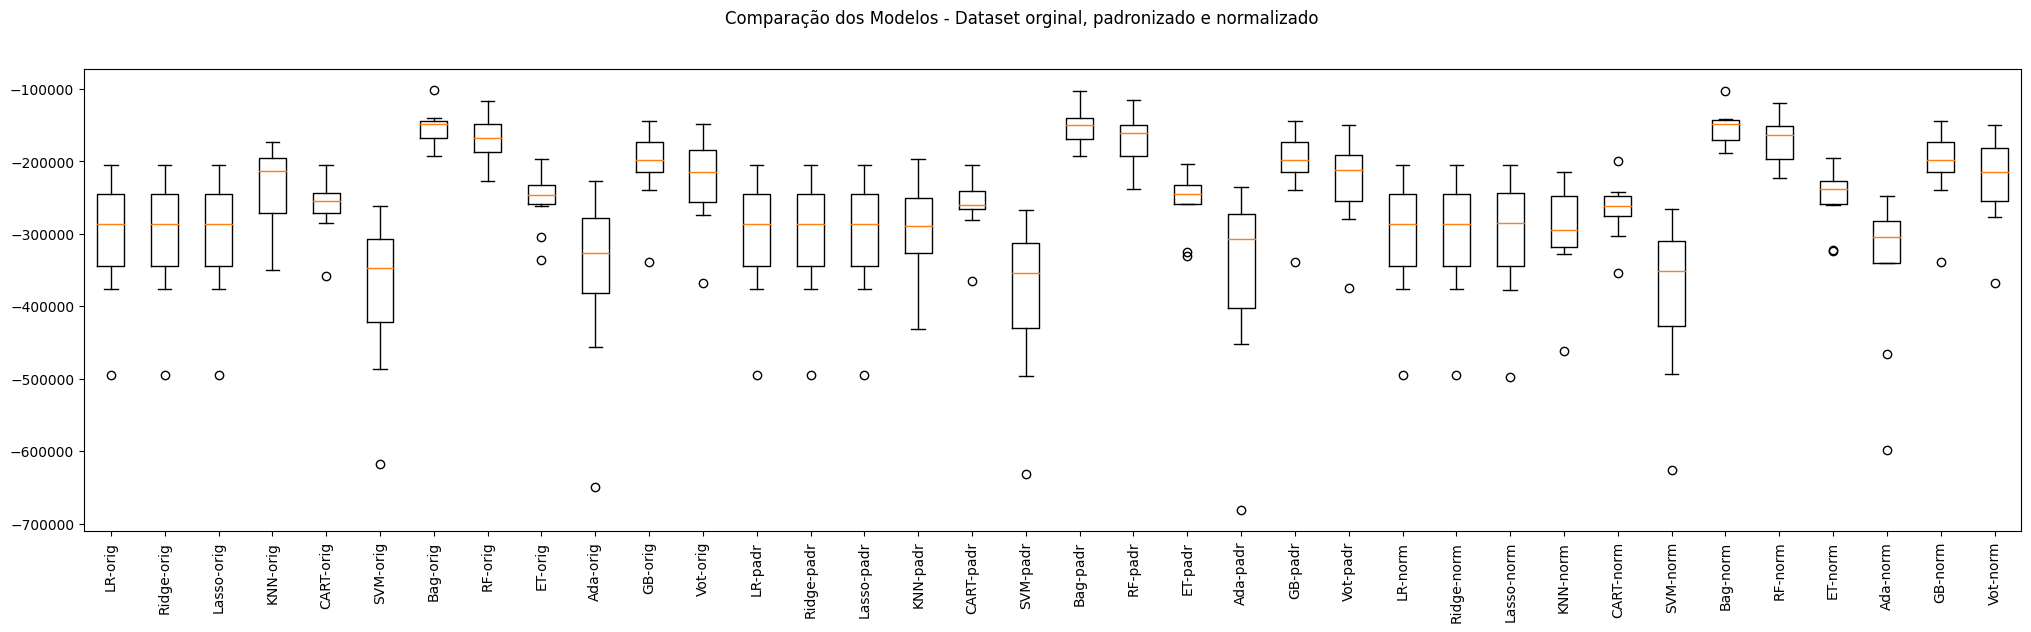

In [29]:
# Listas para armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Definindo os parâmetros base para os diversos ensembles
base = DecisionTreeRegressor()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
bases.append(('logistic', LinearRegression()))
bases.append(('cart', DecisionTreeRegressor()))
bases.append(('svm', SVR()))


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
lin_reg = ('LR', LinearRegression())
ridge = ('Ridge', Ridge())
lasso = ('Lasso', Lasso())
knn = ('KNN', KNeighborsRegressor())
cart = ('CART', DecisionTreeRegressor())
svm = ('SVM', SVR())
bagging = ('Bag', BaggingRegressor(estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestRegressor(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesRegressor(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostRegressor(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingRegressor(n_estimators=num_trees))
voting = ('Voting', VotingRegressor(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([lin_reg])))
pipelines.append(('Ridge-orig', Pipeline([ridge]))) 
pipelines.append(('Lasso-orig', Pipeline([lasso])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, lin_reg])))
pipelines.append(('Ridge-padr', Pipeline([standard_scaler, ridge]))) 
pipelines.append(('Lasso-padr', Pipeline([standard_scaler, lasso])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging]))) 
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, lin_reg]))) 
pipelines.append(('Ridge-norm', Pipeline([min_max_scaler, ridge]))) 
pipelines.append(('Lasso-norm', Pipeline([min_max_scaler, lasso]))) 
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging]))) 
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names, rotation=90)
plt.show()

Percebe-se que os modelos de ensemble Bagging obtiveram os melhores resultados, com menor erro. Portanto, vamos realizar o fine tuning desses modelos e selecionar o que obtiver melhor resultado:

In [ ]:
# Tuning do Bagging Regressor
bagging = ('Bag', BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=100))
pipelines = []

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Definindo os componentes do pipeline
pipelines.append(('Bag-orig', Pipeline(steps=[bagging])))
pipelines.append(('Bag-padr', Pipeline(steps=[standard_scaler, bagging])))
pipelines.append(('Bag-norm', Pipeline(steps=[min_max_scaler, bagging])))

param_grid = {
    'Bag__n_estimators': [100,200,300,400,500],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:    
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("%s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Bag-orig - Melhor: -0.437529 usando {'Bag__n_estimators': 500}


O modelo com menor erro e escolhido foi o Bagging com padronização com 500 estimadores base (n_estimators=500).

### Avaliação de resultados

In [32]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledTrainX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=500)
model.fit(rescaledTrainX, y_train)

# Predições no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)

# Estimando o MSE e o RMSE no conjunto de teste
mse = mean_squared_error(y_test, predictions)
print("MSE %0.2f" % mse)
print("RMSE %0.2f" % np.sqrt(abs(mse)))

MSE 176240.34
RMSE 419.81


Para avaliar o modelo, vamos selecionar as cinco maiores categorias e dez maiores cidades em termos de receita e plotar seus gráficos demonstrando os valores realizados vs projetados.

In [33]:
# agrupa a soma da receita por categoria
top_categories = revenue_data.groupby('product_category_name')['revenue'].sum().reset_index()
# seleciona as cinco categorias com maior receita
top_categories = top_categories.sort_values(by='revenue', ascending=False).head(5)
top_categories = top_categories['product_category_name'].tolist()
top_categories

['beleza_saude',
 'relogios_presentes',
 'cama_mesa_banho',
 'esporte_lazer',
 'informatica_acessorios']

In [34]:
# agrupa a soma da receita por cidade
top_cities = revenue_data.groupby('customer_loc')['revenue'].sum().reset_index()
# seleciona as dez cidades com maior receita
top_cities = top_cities.sort_values(by='revenue', ascending=False).head(10)
top_cities = top_cities['customer_loc'].tolist()
top_cities

['sao paulo, SP',
 'rio de janeiro, RJ',
 'belo horizonte, MG',
 'brasilia, DF',
 'curitiba, PR',
 'porto alegre, RS',
 'campinas, SP',
 'salvador, BA',
 'guarulhos, SP',
 'niteroi, RJ']

In [35]:
year = 2018
month = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
category = top_categories
city = top_cities
X_input = []

predictions = pd.DataFrame(columns=['Year', 'Month', 'Category', 'City', 'Actual_Revenue'])

# Percorre cada combinação de mês, categoria e cidade
for m in month:
    for cat in category:
        for c in city:
            # Busca o valor da receita realizada para o ano, mês, categoria e cidade
            actual = revenue_data.loc[(revenue_data['order_year'] == year) &
                                      (revenue_data['order_month'] == m) &
                                      (revenue_data['product_category_name'] == cat) &
                                      (revenue_data['customer_loc'] == c),
                                      'revenue']
            # Caso seja nulo - não haja receita realizada para esta categoria e cidade no período - recebe valor nulo
            try: 
                actual = actual.iloc[0]
            except IndexError:
                actual = None
            
            # Adiciona uma nova linha no dataframe predictions
            predictions.loc[len(predictions)] = [year, m, cat, c, actual]
            
            # Busca o valor da codificação alvo para a categoria e cidade
            category_mean_rev = category_encoding.loc[category_encoding['product_category_name'] == cat, 'category_mean_rev']
            location_mean_rev = location_encoding.loc[location_encoding['customer_loc'] == c, 'location_mean_rev']
            
            # Adiciona uma nova linha no input de dados a ser usado para predição dos resultados
            X_input.append([year, m, category_mean_rev.iloc[0], location_mean_rev.iloc[0]])

rescaledX_input = scaler.transform(X_input) # aplicação da padronização
predictions['Estimated_Revenue'] = model.predict(rescaledX_input)
predictions

,Year,Month,Category,City,Actual_Revenue,Estimated_Revenue
0,2018,1,beleza_saude,"sao paulo, SP",12688.66,12600.70206
1,2018,1,beleza_saude,"rio de janeiro, RJ",3777.95,4660.90456
2,2018,1,beleza_saude,"belo horizonte, MG",1802.82,1762.66456
3,2018,1,beleza_saude,"brasilia, DF",968.95,1458.00148
4,2018,1,beleza_saude,"curitiba, PR",2048.08,1503.95480
...,...,...,...,...,...,...
595,2018,12,informatica_acessorios,"porto alegre, RS",NaN,550.91592
596,2018,12,informatica_acessorios,"campinas, SP",NaN,356.92758
597,2018,12,informatica_acessorios,"salvador, BA",NaN,314.92070
598,2018,12,informatica_acessorios,"guarulhos, SP",NaN,522.95300


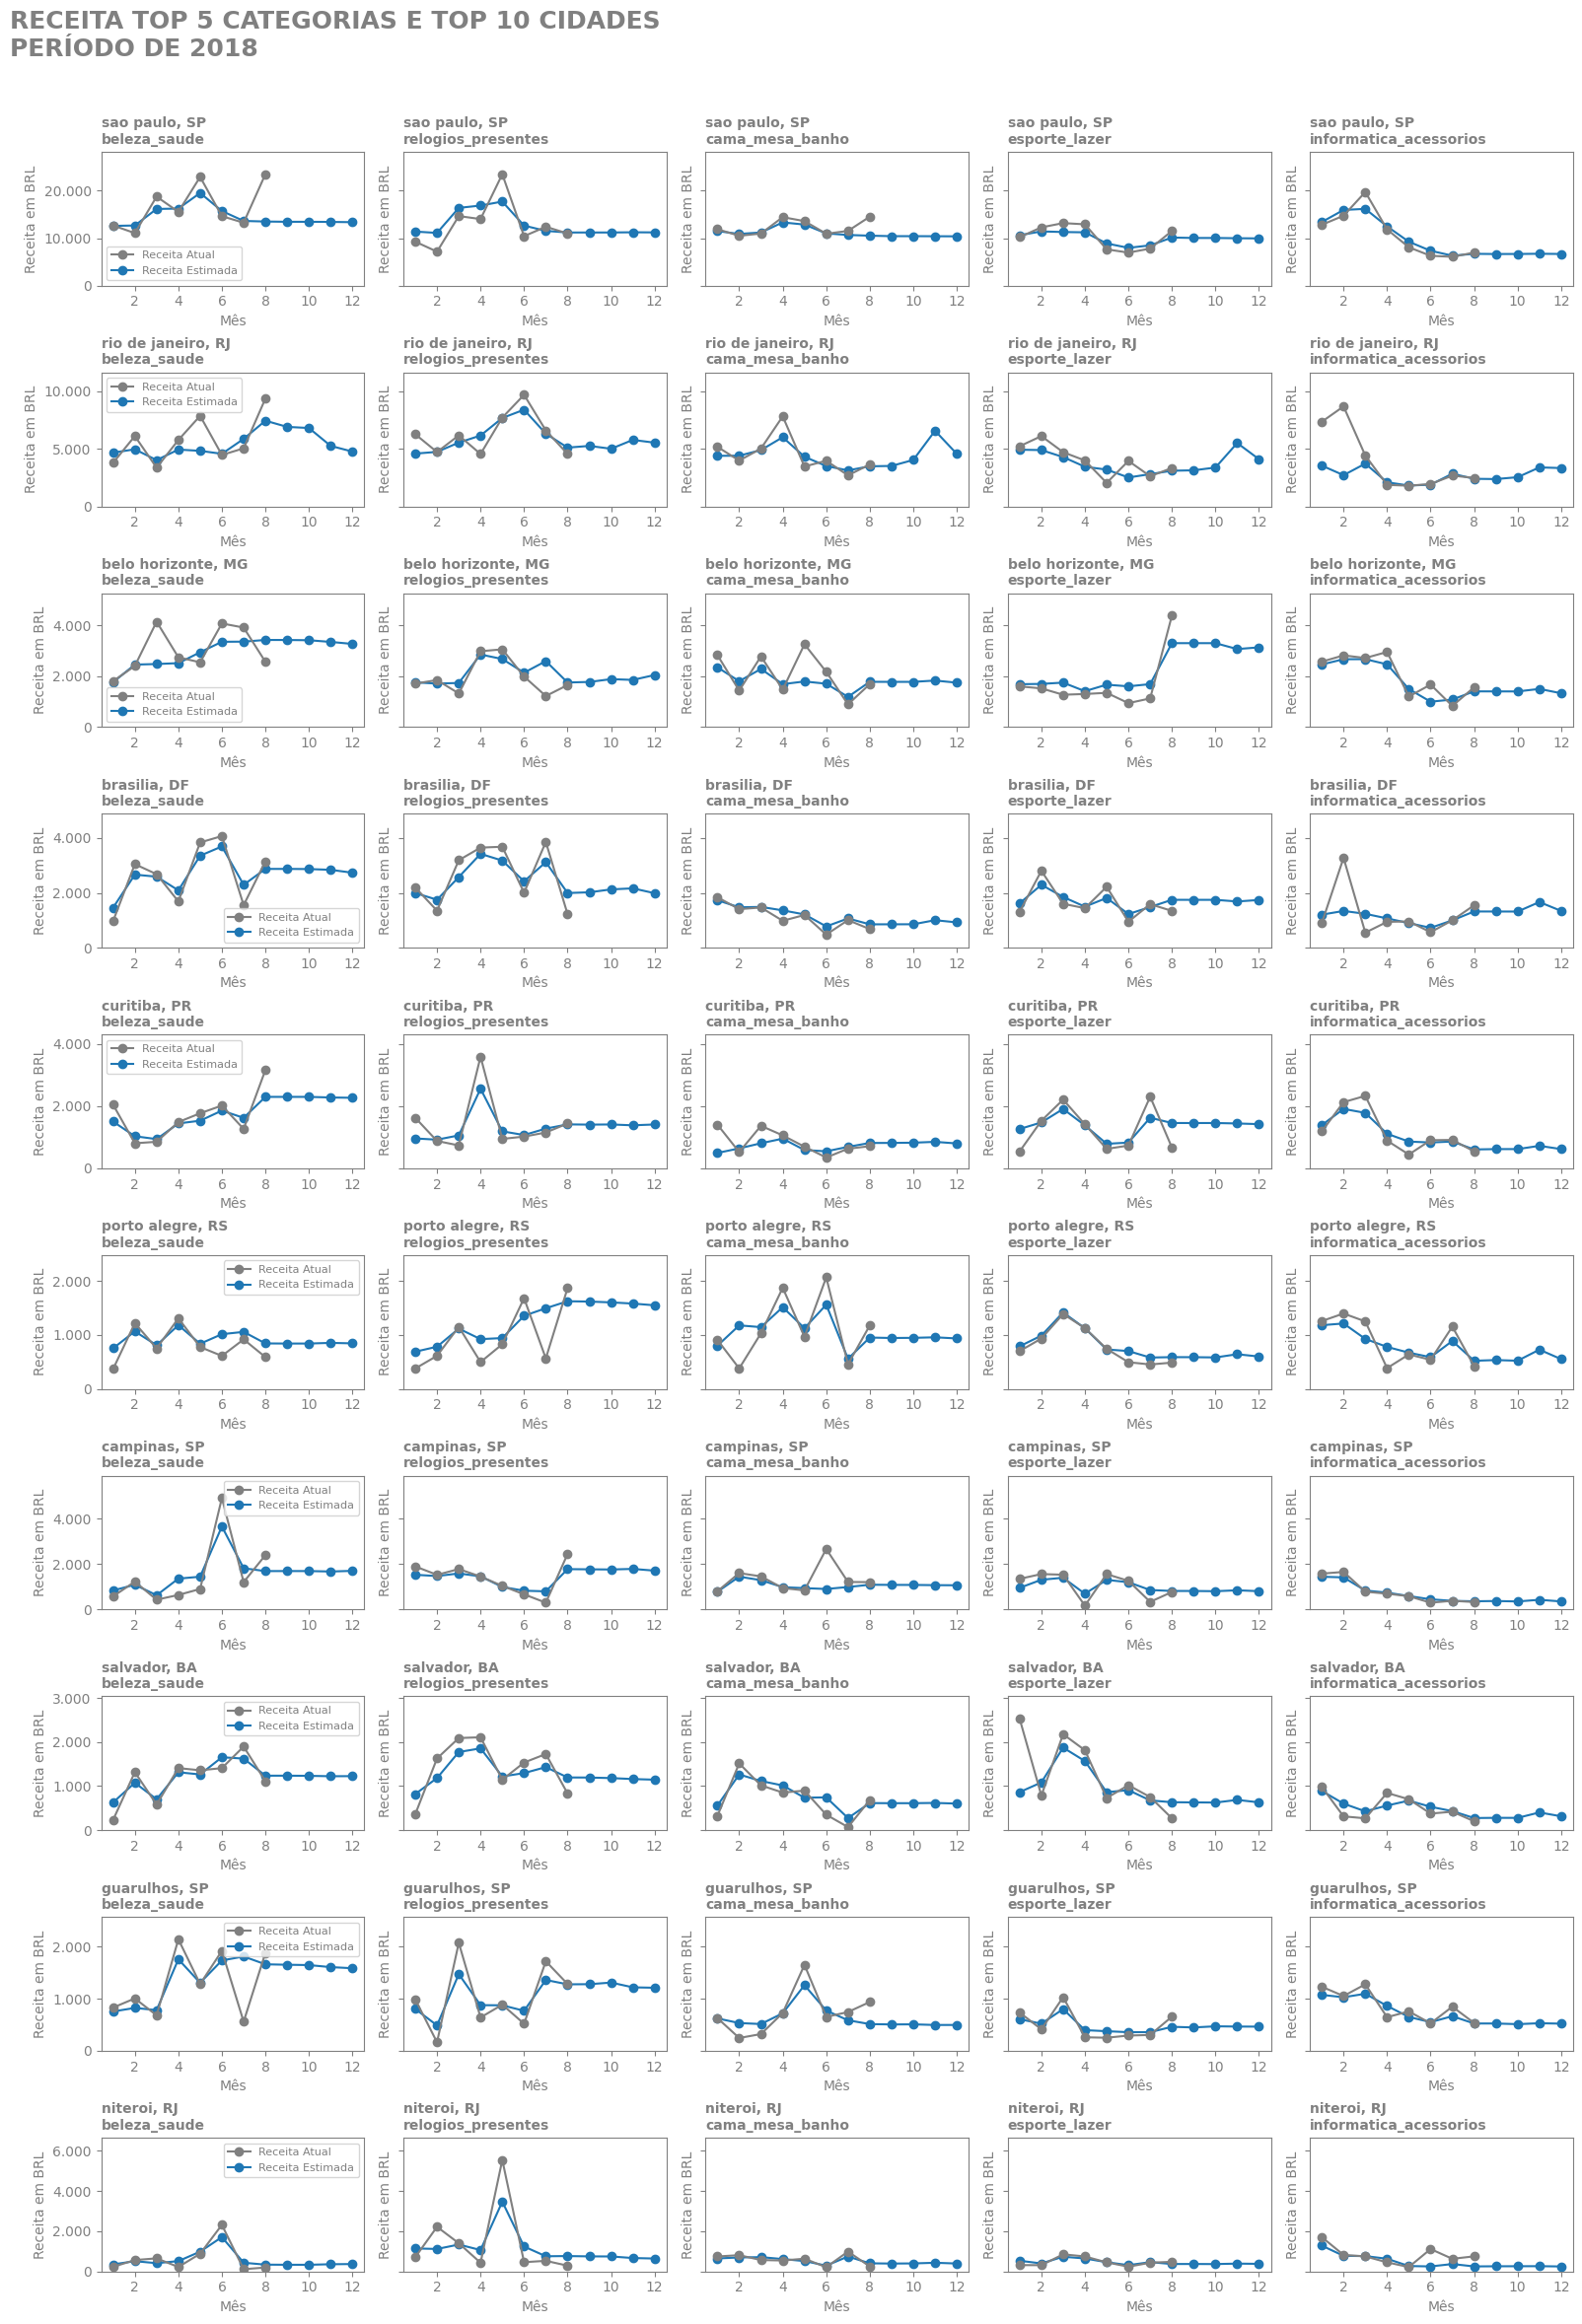

In [36]:
# Criação dos subplots
fig, axs = plt.subplots(len(city), len(category), figsize=(16, 24), sharey='row')

# Loop para preencher cada subplot
for i, c in enumerate(city):
    for j, cat in enumerate(category):
        # Filtra o DataFrame para a cidade e o produto específico
        pred_filtered = predictions[(predictions['City'] == c) & (predictions['Category'] == cat)]
        
        # Obtém os dados relevantes para o gráfico
        months = pred_filtered['Month']
        actual_revenue = pred_filtered['Actual_Revenue']
        estimated_revenue = pred_filtered['Estimated_Revenue']
        top_actual_revenue_by_city = predictions[(predictions['City'] == c)]['Actual_Revenue'].max()
        
        # Plota o gráfico no subsubplot correspondente
        axs[i, j].plot(months, actual_revenue, marker='o', label='Receita Atual', color='gray', markerfacecolor='gray')
        axs[i, j].plot(months, estimated_revenue, marker='o', label='Receita Estimada')
        
        # Define a ordem de sobreposição das séries de dados
        axs[i, j].lines[0].set_zorder(2)
        axs[i, j].lines[1].set_zorder(1)
        
        # Adiciona rótulos e título para cada subplot
        axs[i, j].set_xlabel('Mês', color='gray')
        axs[i, j].set_ylabel('Receita em BRL', color='gray')
        axs[i, j].set_title(f'{c}\n{cat}', fontsize=10, loc='left', fontweight='bold', color='gray')
        
        # Adiciona legenda apenas no primeiro subplot de cada linha
        if j == 0:
            axs[i, j].legend(fontsize=8, labelcolor='gray')
        
        # Ajusta a escala do eixo da receita para cada cidade
        axs[i, j].set_ylim([0, 1.2*top_actual_revenue_by_city])
        
        # Define os valores do eixo 'mês' como inteiros
        axs[i, j].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        
        # Formata os valores do eixo y com pontuação de milhares
        axs[i, j].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}'.replace(',', '.')))
        
        # Configura a cor dos elementos do subplot para cinza
        axs[i, j].tick_params(axis='x', colors='gray')
        axs[i, j].tick_params(axis='y', colors='gray')
        axs[i, j].spines['top'].set_color('gray')
        axs[i, j].spines['bottom'].set_color('gray')
        axs[i, j].spines['left'].set_color('gray')
        axs[i, j].spines['right'].set_color('gray')
        
# Ajusta o espaçamento entre os subplots
plt.tight_layout()

# Ajusta os espaçamentos para criar um espaço vazio acima dos subplots
fig.subplots_adjust(top=0.92)

# Adiciona título
fig.suptitle('RECEITA TOP 5 CATEGORIAS E TOP 10 CIDADES\nPERÍODO DE 2018', x=0, ha='left', fontsize=18, fontweight='bold', color='gray')

# Exibe o gráfico
plt.show()

Pode-se perceber que não houve overfitting do modelo, a linha projetada segue a tendência dos dados mas não se ajusta a oscilações repentinas (prováveis outliers).

Agora, vamos treinar o modelo com todo o dataset:

In [37]:
# Preparação do modelo com todo o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com todo o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com todo o dataset
model.fit(rescaledX, y)

BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=500)

In [38]:
predictions['Estimated_Revenue'] = model.predict(rescaledX_input)
predictions

,Year,Month,Category,City,Actual_Revenue,Estimated_Revenue
0,2018,1,beleza_saude,"sao paulo, SP",12688.66,12949.44088
1,2018,1,beleza_saude,"rio de janeiro, RJ",3777.95,4185.87448
2,2018,1,beleza_saude,"belo horizonte, MG",1802.82,1888.95994
3,2018,1,beleza_saude,"brasilia, DF",968.95,1472.91090
4,2018,1,beleza_saude,"curitiba, PR",2048.08,1518.18392
...,...,...,...,...,...,...
595,2018,12,informatica_acessorios,"porto alegre, RS",NaN,518.22220
596,2018,12,informatica_acessorios,"campinas, SP",NaN,342.23718
597,2018,12,informatica_acessorios,"salvador, BA",NaN,518.22220
598,2018,12,informatica_acessorios,"guarulhos, SP",NaN,402.32380


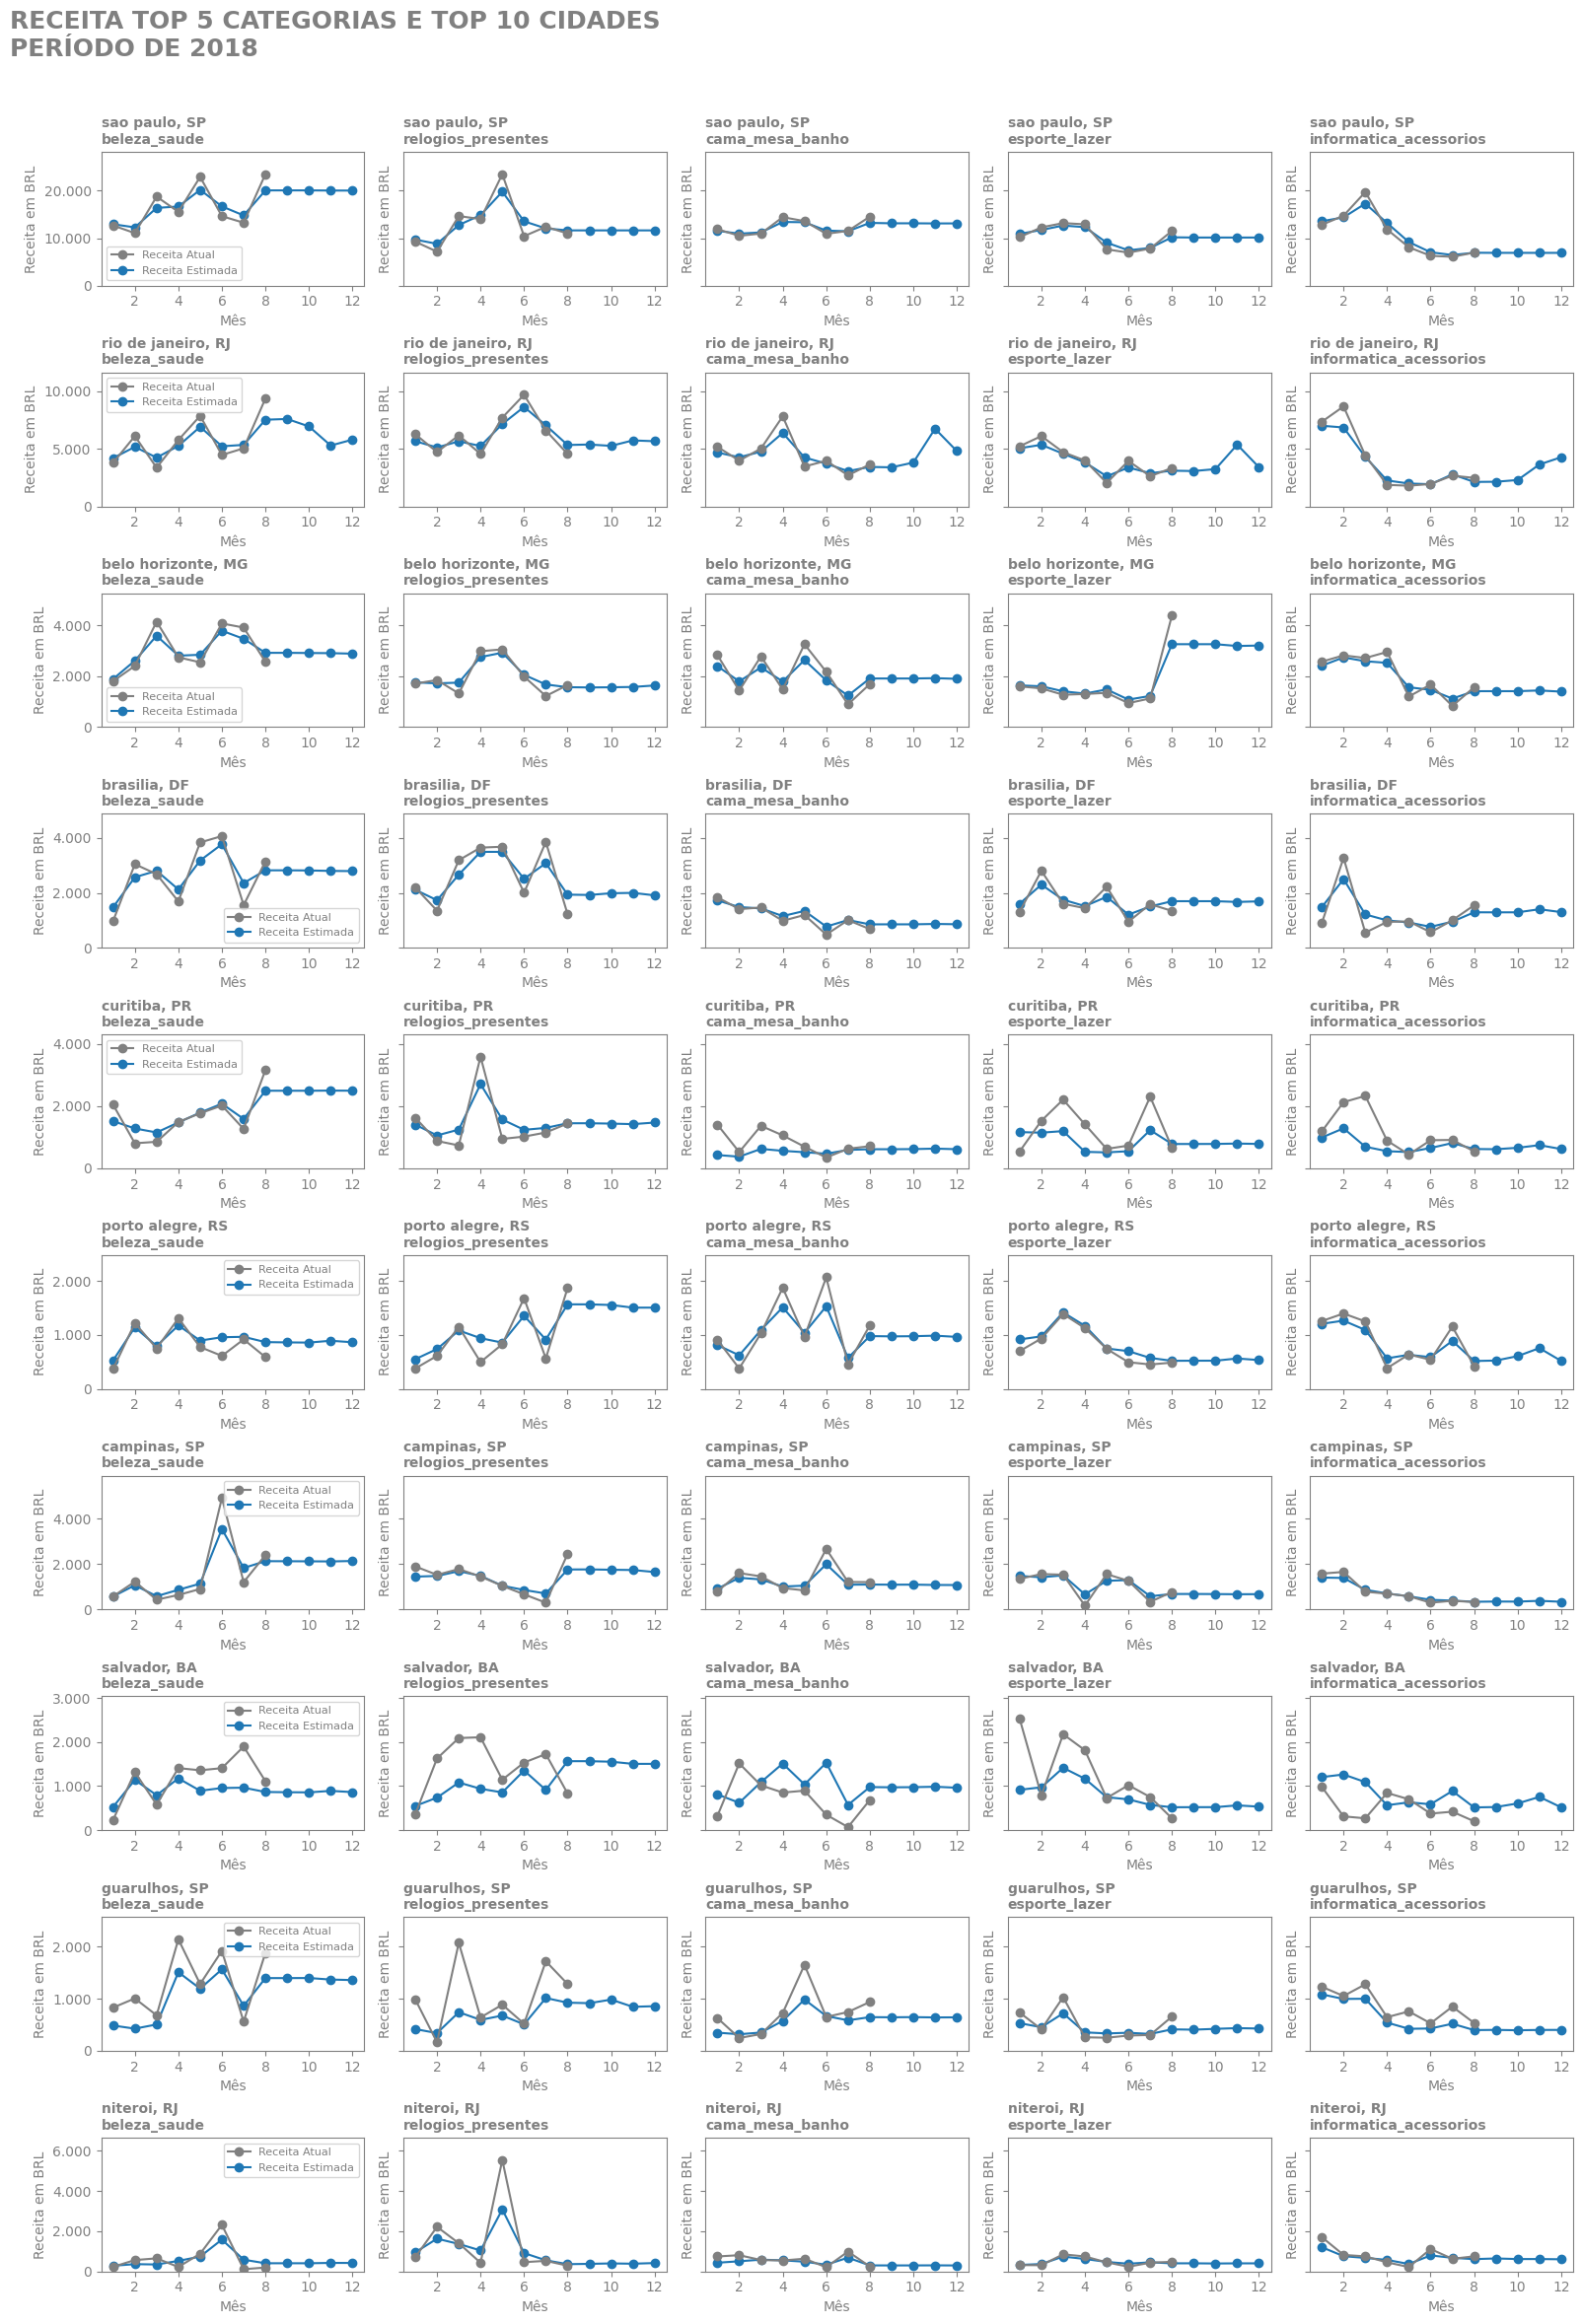

In [39]:
# Criação dos subplots
fig, axs = plt.subplots(len(city), len(category), figsize=(16, 24), sharey='row')

# Loop para preencher cada subplot
for i, c in enumerate(city):
    for j, cat in enumerate(category):
        # Filtra o DataFrame para a cidade e o produto específico
        pred_filtered = predictions[(predictions['City'] == c) & (predictions['Category'] == cat)]
        
        # Obtém os dados relevantes para o gráfico
        months = pred_filtered['Month']
        actual_revenue = pred_filtered['Actual_Revenue']
        estimated_revenue = pred_filtered['Estimated_Revenue']
        top_actual_revenue_by_city = predictions[(predictions['City'] == c)]['Actual_Revenue'].max()
        
        # Plota o gráfico no subsubplot correspondente
        axs[i, j].plot(months, actual_revenue, marker='o', label='Receita Atual', color='gray', markerfacecolor='gray')
        axs[i, j].plot(months, estimated_revenue, marker='o', label='Receita Estimada')
        
        # Define a ordem de sobreposição das séries de dados
        axs[i, j].lines[0].set_zorder(2)
        axs[i, j].lines[1].set_zorder(1)
        
        # Adiciona rótulos e título para cada subplot
        axs[i, j].set_xlabel('Mês', color='gray')
        axs[i, j].set_ylabel('Receita em BRL', color='gray')
        axs[i, j].set_title(f'{c}\n{cat}', fontsize=10, loc='left', fontweight='bold', color='gray')
        
        # Adiciona legenda apenas no primeiro subplot de cada linha
        if j == 0:
            axs[i, j].legend(fontsize=8, labelcolor='gray')
        
        # Ajusta a escala do eixo da receita para cada cidade
        axs[i, j].set_ylim([0, 1.2*top_actual_revenue_by_city])
        
        # Define os valores do eixo 'mês' como inteiros
        axs[i, j].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        
        # Formata os valores do eixo y com pontuação de milhares
        axs[i, j].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}'.replace(',', '.')))
        
        # Configura a cor dos elementos do subplot para cinza
        axs[i, j].tick_params(axis='x', colors='gray')
        axs[i, j].tick_params(axis='y', colors='gray')
        axs[i, j].spines['top'].set_color('gray')
        axs[i, j].spines['bottom'].set_color('gray')
        axs[i, j].spines['left'].set_color('gray')
        axs[i, j].spines['right'].set_color('gray')
        
# Ajusta o espaçamento entre os subplots
plt.tight_layout()

# Ajusta os espaçamentos para criar um espaço vazio acima dos subplots
fig.subplots_adjust(top=0.92)

# Adiciona título
fig.suptitle('RECEITA TOP 5 CATEGORIAS E TOP 10 CIDADES\nPERÍODO DE 2018', x=0, ha='left', fontsize=18, fontweight='bold', color='gray')

# Exibe o gráfico
plt.show()

Novamente, não parece haver overfitting do modelo.

## (b) Modelo de processamento de linguagem natural para análise de sentimentos de review de clientes

### Pré-processamento de dados

In [40]:
# importando bibliotecas restantes
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

In [41]:
order_reviews = pd.read_csv ('https://raw.githubusercontent.com/vitorjannes/ecommerce_data/main/olist_order_reviews_dataset.csv', parse_dates=['review_creation_date','review_answer_timestamp'])
order_reviews.head(10)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53
5,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13,2018-04-16 00:39:37
6,07f9bee5d1b850860defd761afa7ff16,e48aa0d2dcec3a2e87348811bcfdf22b,5,NaN,NaN,2017-07-16,2017-07-18 19:30:34
7,7c6400515c67679fbee952a7525281ef,c31a859e34e3adac22f376954e19b39d,5,NaN,NaN,2018-08-14,2018-08-14 21:36:06
8,a3f6f7f6f433de0aefbb97da197c554c,9c214ac970e84273583ab523dfafd09b,5,NaN,NaN,2017-05-17,2017-05-18 12:05:37
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22,2018-05-23 16:45:47


In [42]:
# resumo estatístico
order_reviews.describe(include='all', datetime_is_numeric=True)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
count,99224,99224,99224.000000,11568,40977,99224,99224
unique,98410,98673,NaN,4527,36159,NaN,NaN
top,7b606b0d57b078384f0b58eac1d41d78,c88b1d1b157a9999ce368f218a407141,NaN,Recomendo,Muito bom,NaN,NaN
freq,3,3,NaN,423,230,NaN,NaN
mean,NaN,NaN,4.086421,NaN,NaN,2018-01-12 20:49:23.948238336,2018-01-16 00:23:56.977938688
min,NaN,NaN,1.000000,NaN,NaN,2016-10-02 00:00:00,2016-10-07 18:32:28
25%,NaN,NaN,4.000000,NaN,NaN,2017-09-23 00:00:00,2017-09-27 01:53:27.249999872
50%,NaN,NaN,5.000000,NaN,NaN,2018-02-02 00:00:00,2018-02-04 22:41:47.500000
75%,NaN,NaN,5.000000,NaN,NaN,2018-05-16 00:00:00,2018-05-20 12:11:21.500000
max,NaN,NaN,5.000000,NaN,NaN,2018-08-31 00:00:00,2018-10-29 12:27:35


As notas dos reviews (coluna 'review_score') vão de 1 a 5, sendo 1 a pior nota e 5 a melhor.

Além disso, nota-se que há dois atributos com informações textuais dos reviews, 'review_comment_title' e 'review_comment_message'. 

Para obter o máximo de informações possível como input para o modelo, será realizada a junção destes dois atributos em um só, de forma que o novo atributo criado contenha todas as informações textuais disponíveis na base de dados.

In [43]:
# cria um novo atributo 'review_text' concatenando dois atributos
order_reviews['review_text'] = order_reviews['review_comment_title'].fillna('') + ' ' + order_reviews['review_comment_message'].fillna('')

In [44]:
# filtra somente as linhas que possuem algum texto de review
order_reviews = order_reviews[(order_reviews['review_text'] != ' ') & (order_reviews['review_text'] != None)]

order_reviews.head(10)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_text
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06,Recebi bem antes do prazo estipulado.
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53,Parabéns lojas lannister adorei comprar pela ...
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22,2018-05-23 16:45:47,recomendo aparelho eficiente. no site a marca ...
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,NaN,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16,2018-02-20 10:52:22,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",2018-05-23,2018-05-24 03:00:01,"Super recomendo Vendedor confiável, produto ok..."
16,9314d6f9799f5bfba510cc7bcd468c01,0dacf04c5ad59fd5a0cc1faa07c34e39,2,NaN,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...",2018-01-18,2018-01-20 21:25:45,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI ..."
19,373cbeecea8286a2b66c97b1b157ec46,583174fbe37d3d5f0d6661be3aad1786,1,Não chegou meu produto,Péssimo,2018-08-15,2018-08-15 04:10:37,Não chegou meu produto Péssimo
22,d21bbc789670eab777d27372ab9094cc,4fc44d78867142c627497b60a7e0228a,5,Ótimo,Loja nota 10,2018-07-10,2018-07-11 14:10:25,Ótimo Loja nota 10
24,0e0190b9db53b689b285d3f3916f8441,79832b7cb59ac6f887088ffd686e1d5e,5,NaN,obrigado pela atençao amim dispensada,2017-12-01,2017-12-09 22:58:58,obrigado pela atençao amim dispensada
27,fe3db7c069d694bab50cc43463f91608,2ca73e2ff9e3a186ad1e1ffb9b1d9c10,5,NaN,A compra foi realizada facilmente.\r\nA entreg...,2018-03-23,2018-04-01 00:27:51,A compra foi realizada facilmente.\r\nA entre...


As datas e IDs dos reviews não trazem informações relevantes para o modelo em questão.

In [45]:
# filtra somente os dois atributos que importam para o modelo
order_reviews = order_reviews[['review_score', 'review_text']]
order_reviews.reset_index(drop=True, inplace=True)

order_reviews.head(10)

,review_score,review_text
0,5,Recebi bem antes do prazo estipulado.
1,5,Parabéns lojas lannister adorei comprar pela ...
2,4,recomendo aparelho eficiente. no site a marca ...
3,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
4,5,"Super recomendo Vendedor confiável, produto ok..."
5,2,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI ..."
6,1,Não chegou meu produto Péssimo
7,5,Ótimo Loja nota 10
8,5,obrigado pela atençao amim dispensada
9,5,A compra foi realizada facilmente.\r\nA entre...


In [46]:
order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42706 entries, 0 to 42705
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   review_score  42706 non-null  int64 
 1   review_text   42706 non-null  object
dtypes: int64(1), object(1)
memory usage: 667.4+ KB


Não há valores nulos restantes.

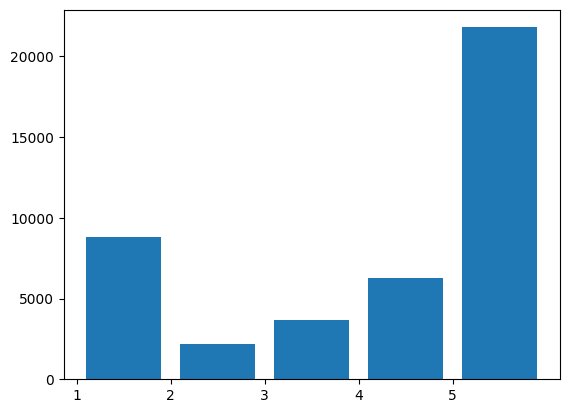

In [47]:
# Plota o histograma
plt.hist(order_reviews['review_score'], bins=5, range=(1, 6), rwidth=0.8)

# Define os rótulos do eixo x para representar as notas 1 a 5
plt.xticks(range(1, 6))

# Mostra o gráfico
plt.show()

Observa-se que a distribuição das notas é bastante desigual, tendendo para avaliações positivas. O que pode dificultar o trabalho do modelo.

Para processar os dados, é realizada a remoção de caracteres especiais, conversão para minúsculas, tokenização e a remoção de stopwords:

In [48]:
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('portuguese'))

def preprocess_text(text):
    # Remove caracteres especiais e converte para minúsculas
    text = text.lower().replace('[^\w\s]', '')
    # Tokenização
    tokens = word_tokenize(text)
    # Remoção de stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # Junta os tokens em uma única string
    processed_text = ' '.join(tokens)
    return processed_text

order_reviews['review_text'] = order_reviews['review_text'].apply(preprocess_text)

order_reviews.info()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42706 entries, 0 to 42705
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   review_score  42706 non-null  int64 
 1   review_text   42706 non-null  object
dtypes: int64(1), object(1)
memory usage: 667.4+ KB


Após o tratamento dos dados, não há nulos restantes.

In [49]:
order_reviews

,review_score,review_text
0,5,recebi bem antes prazo estipulado .
1,5,parabéns lojas lannister adorei comprar intern...
2,4,recomendo aparelho eficiente . site marca apar...
3,4,"pouco , travando ... valor ta boa ."
4,5,"super recomendo vendedor confiável , produto o..."
...,...,...
42701,4,produto recebi acordo compra realizada !
42702,5,entregou dentro prazo . produto chegou condiçõ...
42703,3,"produto enviado nf , existe venda nf , certeza..."
42704,5,"excelente mochila , entrega super rápida . sup..."


Para input no modelo, vamos criar listas com os valores dos atributos do dataframe e reduzir uma unidade do valor de todas as notas dos reviews:

In [50]:
reviews_text = order_reviews['review_text'].tolist()

print(reviews_text[:10])

['recebi bem antes prazo estipulado .', 'parabéns lojas lannister adorei comprar internet seguro prático parabéns todos feliz páscoa', 'recomendo aparelho eficiente . site marca aparelho impresso 3desinfector chegar outro nome ... atualizar marca correta vez aparelho', 'pouco , travando ... valor ta boa .', 'super recomendo vendedor confiável , produto ok entrega antes prazo .', 'gostaria saber , sempre recebi compra agora decpcionou', 'chegou produto péssimo', 'ótimo loja nota 10', 'obrigado atençao amim dispensada', 'compra realizada facilmente . entrega efetuada antes prazo dado . produto começou usado presente , problemas .']


In [51]:
reviews_score = order_reviews['review_score'].tolist()

print(reviews_score[:10])

[5, 5, 4, 4, 5, 2, 1, 5, 5, 5]


In [52]:
for i in range(len(reviews_score)):
    reviews_score[i] -= 1

print(reviews_score[:10])

[4, 4, 3, 3, 4, 1, 0, 4, 4, 4]


### Modelagem e treinamento

O modelo escolhido foi o Long Short-Term Memory (LSTM), que é um tipo específico de RNN e foi projetado para lidar com o problema do desvanecimento do gradiente. É especialmente eficaz para capturar dependências de longo prazo em sequências de texto, o que é fundamental em muitas tarefas de PLN, como análise de sentimentos, onde a compreensão do contexto e das relações entre palavras em uma frase é crucial para determinar o sentimento geral do texto. Outros modelos possíveis são Gated Recurrent Unit (GRU), Convolutional Neural Networks (CNN) e Transformer.

In [53]:
# rótulos correspondentes a cada review
labels = np.array(reviews_score)

# Converte os textos pré-processados em sequências de números (índices das palavras)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews_text)
sequences = tokenizer.texts_to_sequences(reviews_text)

# Padroniza as sequências para que tenham o mesmo comprimento
max_sequence_length = 100  # comprimento máximo da sequência
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Divide os dados em conjunto de treinamento e conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Define a arquitetura do modelo
embedding_dim = 100  # dimensão do embedding
hidden_units = 2  # número de unidades ocultas da LSTM

num_classes = 5  # número de classes de sentimento

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

# Compila o modelo
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treina o modelo
batch_size = 256  # tamanho do lote
epochs = 20  # número de épocas de treinamento

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# Avalia o desempenho do modelo
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Epoch 1/20
134/134 [==============================] - 11s 68ms/step - loss: 1.3243 - accuracy: 0.5959 - val_loss: 1.1561 - val_accuracy: 0.6496
Epoch 2/20
134/134 [==============================] - 9s 67ms/step - loss: 1.0568 - accuracy: 0.6744 - val_loss: 1.0118 - val_accuracy: 0.6686
Epoch 3/20
134/134 [==============================] - 9s 68ms/step - loss: 0.9385 - accuracy: 0.6892 - val_loss: 0.9550 - val_accuracy: 0.6740
Epoch 4/20
134/134 [==============================] - 9s 69ms/step - loss: 0.8783 - accuracy: 0.6962 - val_loss: 0.9322 - val_accuracy: 0.6779
Epoch 5/20
134/134 [==============================] - 9s 69ms/step - loss: 0.8403 - accuracy: 0.6993 - val_loss: 0.9197 - val_accuracy: 0.6784
Epoch 6/20
134/134 [==============================] - 9s 69ms/step - loss: 0.8102 - accuracy: 0.7048 - val_loss: 0.9135 - val_accuracy: 0.6769
Epoch 7/20
134/134 [==============================] - 9s 69ms/step - loss: 0.7834 - accuracy: 0.7150 - val_loss: 0.9091 - val_accuracy: 0.678

Observando os resultados, podemos ver que a perda diminuiu gradualmente durante as épocas de treinamento. Já a precisão do conjunto de validação (val_accuracy) não melhorou significativamente, permanecendo em torno de 0.65-0.68.

Na última época, quando o modelo foi avaliado com o conjunto de teste, a perda foi ~1.05 e a precisão foi ~0.65. Isso significa que, em média, o modelo classificou corretamente cerca de 65% das amostras do conjunto de teste.

Com base nesses resultados, podemos dizer que o modelo alcançou um desempenho moderado na tarefa de análise de sentimento. No entanto, há espaço para melhorias.

Uma maneira de "aumentar o conjunto de dados" para tentar melhorar a acurácia do modelo é agrupar as  classes em apenas três. Dessa forma, teríamos as duas notas mais baixas representadas por 0, a nota mediana representada por 1 e as duas notas maiores representadas por 2. Como se tívessemos três sentimentos: negativo, neutro e positivo. Assim, o modelo tem mais dados por classe para processar.

In [54]:
# agrupa as notas dos reviews em três classes
for i in range(len(reviews_score)):
    if reviews_score[i] in [3, 4]:
        reviews_score[i] = 2
    elif reviews_score[i] == 2:
        reviews_score[i] = 1
    elif reviews_score[i] in [0, 1]:
        reviews_score[i] = 0

print(reviews_score[:10])

[2, 2, 2, 2, 2, 0, 0, 2, 2, 2]


In [55]:
# rótulos correspondentes a cada review
labels = np.array(reviews_score)

# Converte os textos pré-processados em sequências de números (índices das palavras)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews_text)
sequences = tokenizer.texts_to_sequences(reviews_text)

# Padroniza as sequências para que tenham o mesmo comprimento
max_sequence_length = 100  # comprimento máximo da sequência
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Divide os dados em conjunto de treinamento e conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Define a arquitetura do modelo
embedding_dim = 100  # dimensão do embedding
hidden_units = 2  # número de unidades ocultas da LSTM

num_classes = 3  # número de classes de sentimento ajustado para 3

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

# Compila o modelo
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treina o modelo
batch_size = 256  # tamanho do lote
epochs = 20  # número de épocas de treinamento

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# Avalia o desempenho do modelo
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Epoch 1/20
134/134 [==============================] - 11s 72ms/step - loss: 0.8975 - accuracy: 0.6577 - val_loss: 0.7342 - val_accuracy: 0.7138
Epoch 2/20
134/134 [==============================] - 9s 71ms/step - loss: 0.6410 - accuracy: 0.7957 - val_loss: 0.5927 - val_accuracy: 0.8151
Epoch 3/20
134/134 [==============================] - 9s 69ms/step - loss: 0.5261 - accuracy: 0.8473 - val_loss: 0.5306 - val_accuracy: 0.8293
Epoch 4/20
134/134 [==============================] - 9s 69ms/step - loss: 0.4594 - accuracy: 0.8625 - val_loss: 0.4998 - val_accuracy: 0.8339
Epoch 5/20
134/134 [==============================] - 9s 69ms/step - loss: 0.4141 - accuracy: 0.8722 - val_loss: 0.4858 - val_accuracy: 0.8355
Epoch 6/20
134/134 [==============================] - 9s 70ms/step - loss: 0.3819 - accuracy: 0.8784 - val_loss: 0.4757 - val_accuracy: 0.8380
Epoch 7/20
134/134 [==============================] - 9s 69ms/step - loss: 0.3565 - accuracy: 0.8839 - val_loss: 0.4744 - val_accuracy: 0.838

O modelo parece estar sofrendo de um ligeiro overfitting, pois a precisão de treinamento continua a aumentar ao longo das épocas, enquanto a precisão de validação parece estagnar ou diminuir após a época 6. Isso pode indicar que o modelo está se ajustando muito bem aos dados de treinamento, mas não está generalizando bem para novos dados.

No entanto, a precisão de teste de 82% é um resultado razoável por ser uma tarefa com classes desbalanceadas.

Ainda é possível tentar aplicar técnicas de regularização - como dropout e regularização L2 - e ajustar hiperparâmetros para melhorar o desempenho do modelo. 

1. Regularização da camada LSTM: Adicionar regularização à camada LSTM pode ajudar a reduzir o overfitting e melhorar a generalização do modelo. Podemos usar, por exemplo, a regularização L2.
2. Ajustar o número de unidades ocultas da LSTM: Tentar aumentar o número de unidades ocultas pode melhorar a capacidade de aprendizado do modelo, desde que não leve a um overfitting excessivo.
3. Utilizar uma camada de Dropout: Adicionar uma camada de Dropout após a camada LSTM pode ser benéfico para reduzir o overfitting e melhorar a precisão do modelo.
4. Aumentar a dimensão do embedding pode permitir que o modelo capture representações mais ricas das palavras, o que pode melhorar o desempenho.

Segue exemplo abaixo:

In [56]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

# Define a arquitetura do modelo
embedding_dim = 150  # dimensão do embedding aumentada
hidden_units = 16  # número de unidades ocultas da LSTM aumentado

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(hidden_units, kernel_regularizer=l2(0.01)))  # Regularização L2 adicionada
model.add(Dropout(0.5))  # Camada de Dropout adicionada
model.add(Dense(num_classes, activation='softmax'))

# Compila o modelo
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treina o modelo
batch_size = 256  # tamanho do lote
epochs = 20  # número de épocas de treinamento

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# Avalia o desempenho do modelo
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Epoch 1/20
134/134 [==============================] - 19s 129ms/step - loss: 1.0386 - accuracy: 0.7515 - val_loss: 0.5820 - val_accuracy: 0.8231
Epoch 2/20
134/134 [==============================] - 17s 125ms/step - loss: 0.5328 - accuracy: 0.8429 - val_loss: 0.5133 - val_accuracy: 0.8427
Epoch 3/20
134/134 [==============================] - 17s 126ms/step - loss: 0.4673 - accuracy: 0.8570 - val_loss: 0.4831 - val_accuracy: 0.8384
Epoch 4/20
134/134 [==============================] - 17s 128ms/step - loss: 0.4348 - accuracy: 0.8652 - val_loss: 0.4701 - val_accuracy: 0.8399
Epoch 5/20
134/134 [==============================] - 17s 126ms/step - loss: 0.4111 - accuracy: 0.8710 - val_loss: 0.4709 - val_accuracy: 0.8425
Epoch 6/20
134/134 [==============================] - 17s 126ms/step - loss: 0.3881 - accuracy: 0.8759 - val_loss: 0.4778 - val_accuracy: 0.8404
Epoch 7/20
134/134 [==============================] - 17s 126ms/step - loss: 0.3702 - accuracy: 0.8810 - val_loss: 0.4843 - val_ac

Com as alterações realizadas, obtivemos uma melhora incremental na precisão de teste, chegando a ~84% nas épocas 2 a 8. Para fins deste exercício é o bastante, mas ainda seria possível testar diferentes arquiteturas e realizar um 'fine tuning' dos hiperparâmetros.